# Linear Regression Using Sklearn API

1. Dataset - California Housing
2. Linear Regression
3. Training : fit, cross_validate
4. Evaluation : score, cross_val_score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, learning_curve, ShuffleSplit, train_test_split, cross_val_predict
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(306)

### ShuffleSplitting

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

## Importing the dataset

In [4]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's Drop the Ocean Proximity for now, I will redo with Ocean Proximity when i will do encoding of categorical values

In [5]:
data = data.drop(columns=['ocean_proximity'])

## Data Exploration is already done in the previous notebook

## Imputing the dataset for missing values

In [6]:
impute = KNNImputer(n_neighbors=2)
imp_data = impute.fit_transform(data)

In [7]:
data = pd.DataFrame(imp_data, columns= data.columns)

## Preprocessing and model building

In [8]:
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']/100000

### Train-test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15480, 8)
(15480,)
(5160, 8)
(5160,)


### Pipeline: processing + model

In [11]:
lin_reg_pipelne = Pipeline([
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_pipelne.fit(X_train,y_train)

,steps,"[('feature_scaler', ...), ('lin_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


#### Now since we have trained the model, let's check the learnt/estimated weight

In [12]:
print("intercept w_0", lin_reg_pipelne[-1].intercept_)
print("weight vector", lin_reg_pipelne[-1].coef_)

intercept w_0 2.0703489205426377
weight vector [-0.8563372  -0.90688575  0.14784883 -0.17797746  0.5053612  -0.43700256
  0.15889046  0.76852688]


## Model Evaluation


### Score

In [13]:
test_score = lin_reg_pipelne.score(X_test, y_test)
print("Model Peformance on test set", test_score)

train_score = lin_reg_pipelne.score(X_train, y_train)
print("Model Peformance on test set", train_score)

Model Peformance on test set 0.6336637798602007
Model Peformance on test set 0.6374794873372915


### Cross-validate Score

In [14]:
lin_reg_score = cross_val_score(lin_reg_pipelne, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)

print(lin_reg_score)

[-0.48755625 -0.48135806 -0.51232427 -0.50833425 -0.53436955 -0.46500896
 -0.49350831 -0.51064953 -0.48161006 -0.50242713]


In [15]:
print("Linear Regression Model Score", lin_reg_score.mean(), "\n", "std:", lin_reg_score.std())

Linear Regression Model Score -0.4977146360694677 
 std: 0.018912329207589323


### Cross-Validation API

In [16]:
lin_reg_cv_results = cross_validate( lin_reg_pipelne, X_train, y_train, cv=cv,
                                    scoring="neg_mean_squared_error", return_train_score=True, return_estimator=True)

In [17]:
lin_reg_cv_results

{'fit_time': array([0.00391507, 0.00282884, 0.00258183, 0.00245714, 0.00241303,
        0.00265193, 0.00259089, 0.00243306, 0.00247025, 0.00314021]),
 'score_time': array([0.00068593, 0.00073409, 0.00063324, 0.00059795, 0.00064301,
        0.0007019 , 0.00065088, 0.00058699, 0.00055385, 0.00069284]),
 'estimator': [Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaler', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_sca

In [18]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error= -1 * lin_reg_cv_results['test_score']

print (f"Mean squared error of linear regression model on the train set: \n" 
       f"{train_error.mean ():.3f} +/- {train_error.std():.3f}")
print (f"Mean squared error of linear regression model on the test set: \n"
       f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the train set: 
0.481 +/- 0.005
Mean squared error of linear regression model on the test set: 
0.498 +/- 0.019


### Selecting Best Model

In [19]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

In [20]:
print("Intercept w_0", selected_model['lin_reg'].intercept_)
print("Coefficients w0,w1...wn", selected_model['lin_reg'].coef_)

Intercept w_0 2.074167797157622
Coefficients w0,w1...wn [-0.84511741 -0.89300343  0.1565094  -0.17820223  0.51320044 -0.417118
  0.13516019  0.7739125 ]


### Model Performance

In [21]:
cv_predictions = cross_val_predict(lin_reg_pipelne, X_train, y_train)

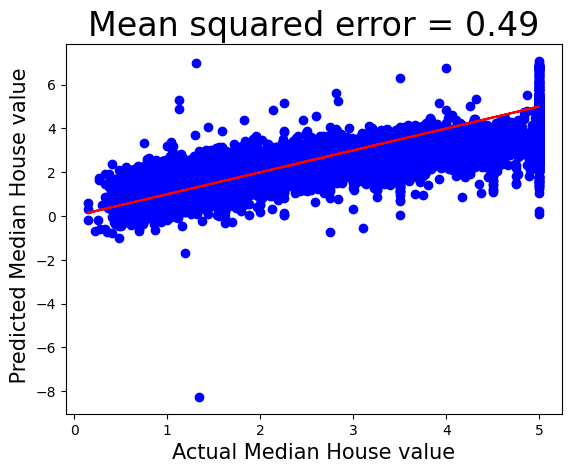

In [22]:
mse_cv = mean_squared_error(y_train, cv_predictions)

plt.scatter(y_train, cv_predictions, color='blue')
plt.plot(y_train, y_train, 'r-')
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel('Actual Median House value', size=15) 
plt.ylabel(' Predicted Median House value', size=15)
plt.show()

## Predictions

In [23]:
test_predictions_cv = selected_model.predict(X_test)
test_predictions_cv[:5]

array([0.58071124, 1.7803052 , 3.03738425, 2.86126058, 2.61860118])

In [24]:
score_cv = selected_model.score(X_test, y_test)

print("Score for best model on Test Dataset is", score_cv)

Score for best model on Test Dataset is 0.6332970421057376


# Baseline Models

In [25]:
from sklearn.model_selection import permutation_test_score
from sklearn.dummy import DummyRegressor

## Linear classifier

In [26]:
lin_reg_cv_results = cross_validate( lin_reg_pipelne, X_train, y_train, cv=cv,
                                    scoring="neg_mean_squared_error", return_train_score=True, return_estimator=True, n_jobs=2)

lin_reg_errors = pd.Series(-lin_reg_cv_results["test_score"], name = "Linear Regression Error")

## Dummy Regressor

In [27]:
def dummy_score_baseline(strategy, constant_val=None, quantile_val = None):
    baseline_model_median = DummyRegressor(strategy=strategy, constant= constant_val, quantile=quantile_val)
    baseline_median_cv_results = cross_validate(baseline_model_median, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2)

    return pd.Series(-baseline_median_cv_results["test_score"], name="Dummy Regressor Error")

In [28]:
baseline_median_cv_results_errors = dummy_score_baseline(strategy='median')
baseline_mean_cv_results_errors = dummy_score_baseline(strategy='mean')
baseline_constant_cv_results_errors = dummy_score_baseline(strategy='constant', constant_val=2)
baseline_quantile_cv_results_errors = dummy_score_baseline(strategy='quantile', quantile_val=0.55)

#### Let's compare performance of these dummy regressors

In [29]:
dummy_error_df = pd.concat([baseline_median_cv_results_errors, baseline_mean_cv_results_errors,
                            baseline_constant_cv_results_errors, baseline_quantile_cv_results_errors], axis=1)

dummy_error_df.columns= ['Median CV', 'Mean CV', 'Constant CV', 'Quamtile CV']

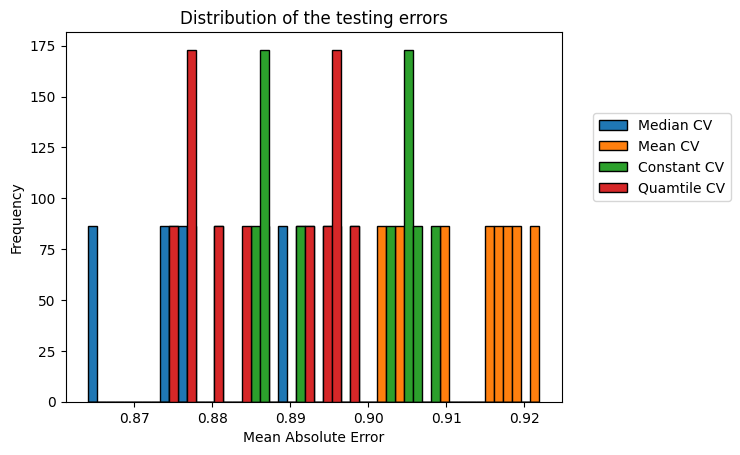

In [30]:
dummy_error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(bbox_to_anchor = (1.05, 0.8), loc = "upper left")
plt.xlabel("Mean Absolute Error")
_ = plt.title( "Distribution of the testing errors")

### Permutation test score

In [31]:
score, permutation_score, pvalue = permutation_test_score(
    lin_reg_pipelne, X_train, y_train,cv=cv, scoring='neg_mean_absolute_error',n_jobs=2, n_permutations=30)

permutation_error = pd.Series(-permutation_score, name="Permuted error")

In [32]:
print(permutation_error)

0     0.914818
1     0.916318
2     0.914770
3     0.911105
4     0.912916
5     0.914281
6     0.916356
7     0.906781
8     0.908759
9     0.915481
10    0.908556
11    0.911912
12    0.918414
13    0.914699
14    0.903870
15    0.912244
16    0.910761
17    0.916914
18    0.905181
19    0.914765
20    0.919881
21    0.916646
22    0.910761
23    0.915488
24    0.910219
25    0.914976
26    0.906726
27    0.908109
28    0.910418
29    0.915512
Name: Permuted error, dtype: float64


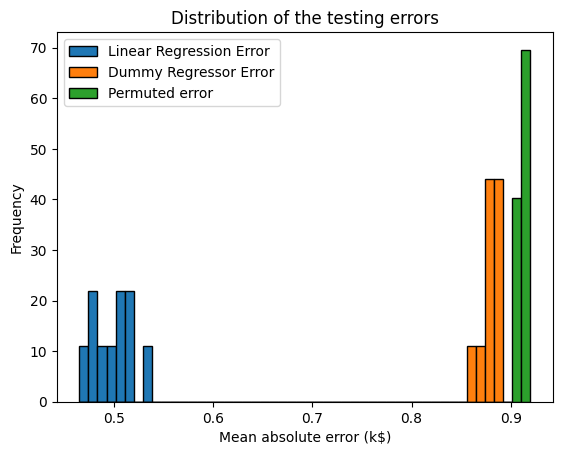

In [33]:
error_df = pd.concat([lin_reg_errors, baseline_median_cv_results_errors, permutation_error], axis=1)

error_df.plot.hist(bins=50, density=True, edgecolor="black")
plt.legend(loc="best")
plt.xlabel( "Mean absolute error (k$)")
_ = plt.title("Distribution of the testing errors")

# Conclusion

Our model has performed far better than Baseline Errir! but it can be imporved even further

# SGDRegressor

In [34]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import validation_curve

In [35]:
X_n_train,  X_n_test, y_n_train, y_n_test = train_test_split(X_train, y_train, random_state=42)

In [36]:
print(X_n_train.shape)
print(X_n_test.shape)
print(y_n_train.shape)
print(y_n_test.shape)

(11610, 8)
(3870, 8)
(11610,)
(3870,)


## Baseline SGD Regressor

In [37]:
sgd = SGDRegressor(random_state=42)
sgd.fit(X_n_train, y_n_train)

train_mae = mean_absolute_error(y_n_train, sgd.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 3092971236677614.5
Mean absolute error on test dataset 3054277940448545.5


## Adding a Feature Scaling step

In [38]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor())
])
sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.5123133865666695
Mean absolute error on test dataset 0.4918227640558841


Error is still high, will run SGD Step by step

## Step-wise training of sGDRegressor

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

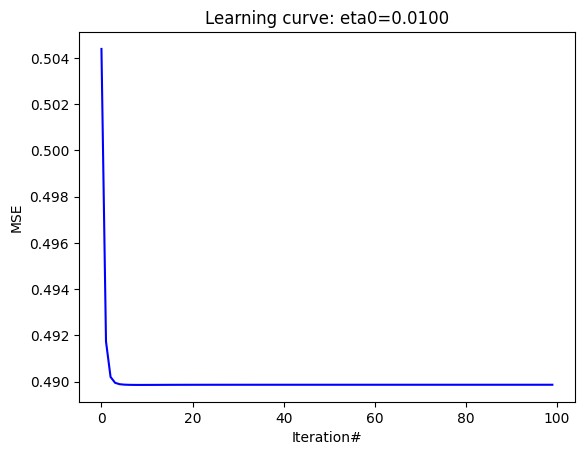

In [39]:
eta0 = 1e-2
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=1, tol=None, 
                         warm_start=True, random_state=42))
])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(X_n_train,y_n_train)
    loss.append(mean_squared_error(y_n_train, sgd_pipeline.predict(X_n_train)))


plt.plot(np.arange(len(loss)), loss,'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')


Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

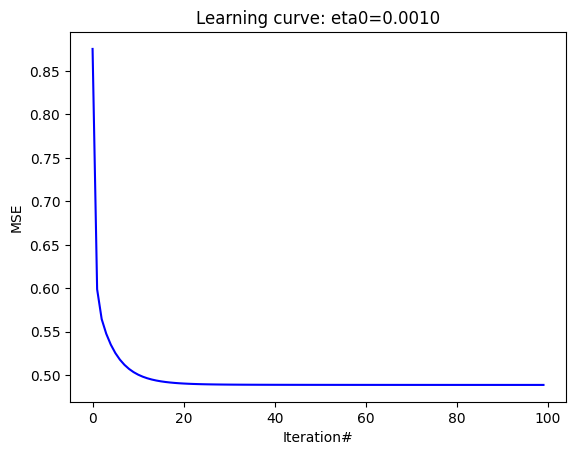

In [40]:
eta0 = 1e-3
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=1, tol=None, 
                         warm_start=True, random_state=42, eta0=eta0))
])

loss = []
for epoch in range(100):
    sgd_pipeline.fit(X_n_train,y_n_train)
    loss.append(mean_squared_error(y_n_train, sgd_pipeline.predict(X_n_train)))


plt.plot(np.arange(len(loss)), loss,'b-')
plt.xlabel('Iteration#')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')


## Fixing through Validation Curve

In [41]:
eta0 = [1e-5, 1e-4, 1e-3, 1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, X_train, y_train, param_name="sgd__eta0"
                                             , param_range=eta0, cv=cv, scoring="neg_mean_squared_error", n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

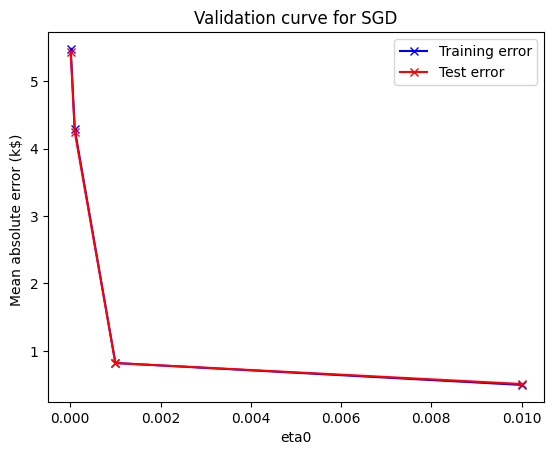

In [42]:
plt.plot(eta0, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(eta0, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()
plt.xlabel("eta0")
plt.ylabel("Mean absolute error (k$) ")
_ = plt.title("Validation curve for SGD")

## SGDRegressor

In [43]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         validation_fraction=0.2,
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.5299750116714608
Mean absolute error on test dataset 0.5078555265263557


In [44]:
print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates:", sgd_pipeline[-1].t_)

Number of SGD iterations:  27
Number of weight updates: 313471.0


### Constant learning Scale

In [45]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         validation_fraction=0.2,
                         learning_rate='constant',
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.512426137910805
Mean absolute error on test dataset 0.49185469368996004


In [46]:
print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates:", sgd_pipeline[-1].t_)

Number of SGD iterations:  10
Number of weight updates: 116101.0


### Adaptive Learning Rate

In [47]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=500,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         validation_fraction=0.2,
                         learning_rate='adaptive',
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.5139155757780741
Mean absolute error on test dataset 0.4939239419040428


In [48]:
print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates:", sgd_pipeline[-1].t_)

Number of SGD iterations:  35
Number of weight updates: 406351.0


## Setting `max_iter`

In [49]:
max_iter = int(np.ceil(1e6/X_train.shape[0]))
max_iter

65

In [50]:
sgd_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("sgd", SGDRegressor(max_iter=max_iter,
                         early_stopping=True,
                         eta0=1e-3,
                         tol=1e-3,
                         validation_fraction=0.2,
                         learning_rate='adaptive',
                         n_iter_no_change=5,
                         average=10,
                         random_state=42))
])

sgd_pipeline.fit(X_n_train, y_n_train)
train_mae = mean_absolute_error(y_n_train, sgd_pipeline.predict(X_n_train))
dev_mae = mean_absolute_error(y_n_test, sgd_pipeline.predict(X_n_test))

print('Mean absolute error on training dataset', train_mae)
print('Mean absolute error on test dataset', dev_mae)

Mean absolute error on training dataset 0.5139155757780741
Mean absolute error on test dataset 0.4939239419040428


In [51]:
print ("Number of SGD iterations: ", sgd_pipeline[-1].n_iter_)
print ("Number of weight updates:", sgd_pipeline[-1].t_)

Number of SGD iterations:  35
Number of weight updates: 406351.0


# K-NN on California Housing Dataset

## Data Exploring

In [52]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

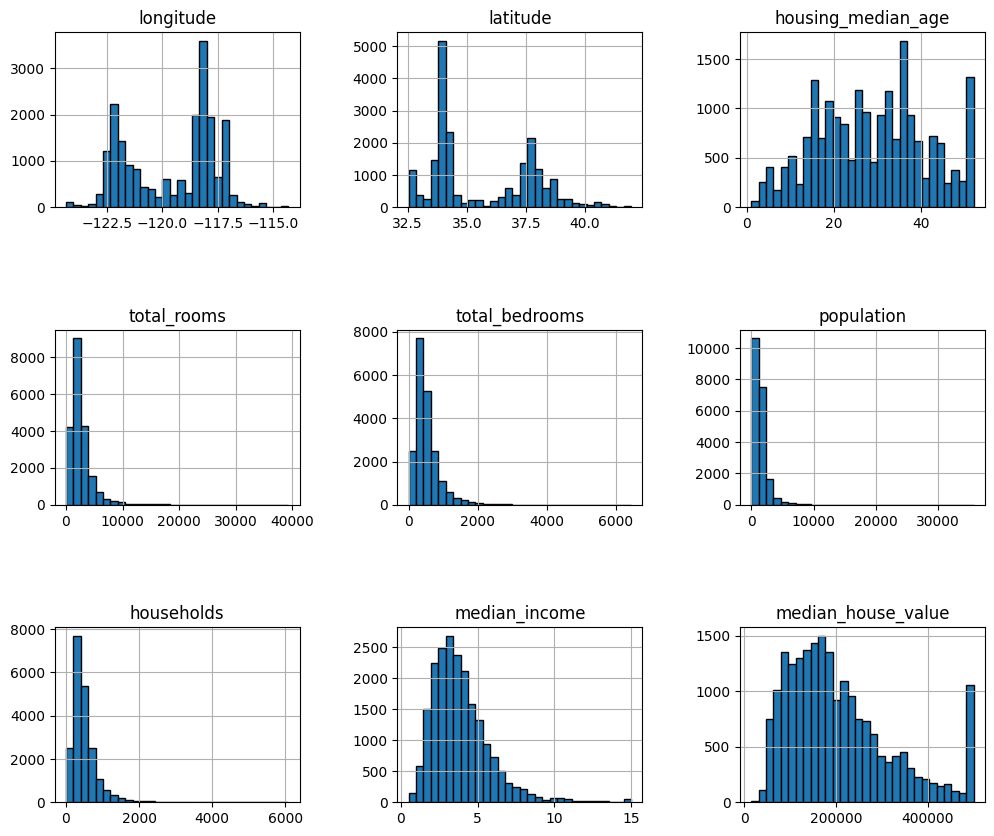

In [53]:
data.hist(figsize=(12,10), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.7, wspace=0.4)

## Model Building

In [54]:
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=2))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

error = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(error)
print(error)

0.45650725519429747


## Model Selection and Evaluation

In [55]:
rmse_val = []

for K in range(1,31):
    pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=K))
    ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    error = np.sqrt(mse)

    rmse_val.append(error)


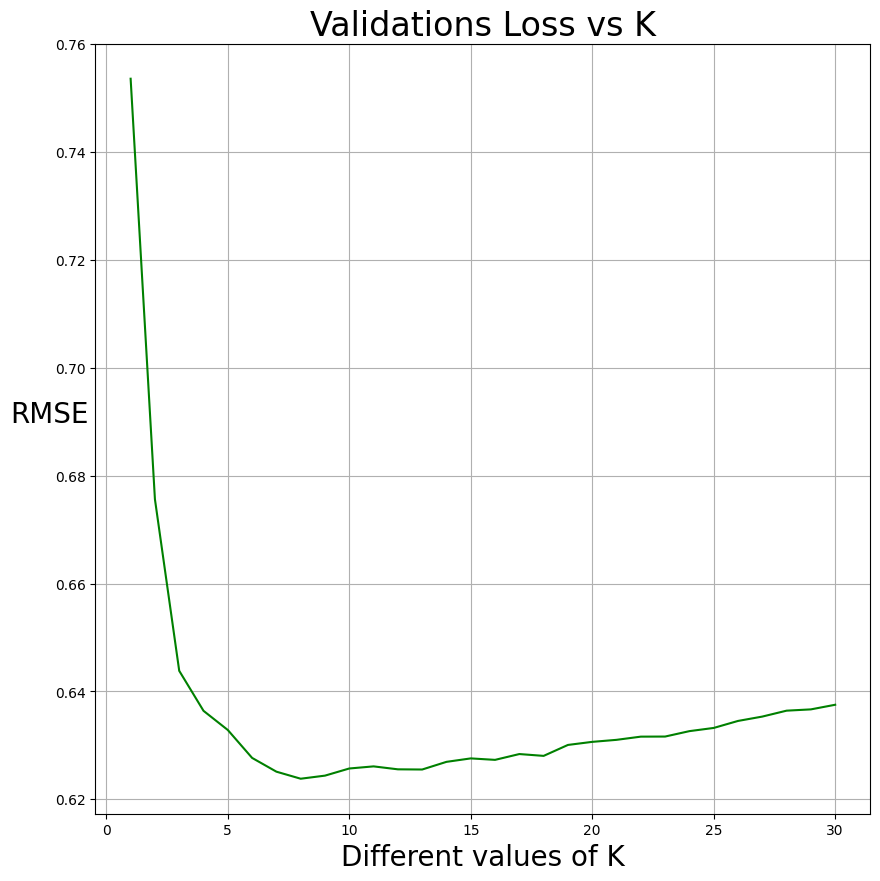

In [56]:
plt.figure (figsize=(10,10))

#plotting the rmse values against k values

plt.plot(range(1, len (rmse_val)+1), rmse_val, color='green')
plt.xlabel('Different values of K', fontsize=20)
plt.ylabel('RMSE', fontsize=20, rotation=0)
plt.grid(True)

# displaying the title
plt.title("Validations Loss vs K", fontsize=24)
plt.show()

## Using GridSearchCV

In [57]:
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid = {'knn__n_neighbors': list(range(1,31))}


gs = GridSearchCV(estimator=pipe, param_grid= param_grid, cv=10, n_jobs=2, return_train_score=True)

gs.fit(X_train, y_train)

,estimator,Pipeline(step...Regressor())])
,param_grid,"{'knn__n_neighbors': [1, 2, ...]}"
,scoring,None
,n_jobs,2
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,feature_range,"(0, ...)"


In [58]:
reg_knn = gs.best_estimator_
print(reg_knn)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=8))])


In [59]:
pred = gs.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, pred)
error = np.sqrt(mse)

print ('RMSE value for k is:', error)

RMSE value for k is: 0.6238249341227757


## Polynomial Features

Commenting it because it takes alot of time to compute

In [60]:
# from sklearn.preprocessing import PolynomialFeatures
# pipe = Pipeline([
#     ('poly', PolynomialFeatures()),
#     ('scale', MinMaxScaler()),
#     ('knn', KNeighborsRegressor())
# ])

# param_grid = {'knn__n_neighbors': list(range(1,31)),
#               'poly__degree': list(range(6,12))}


# gs = GridSearchCV(estimator=pipe, param_grid= param_grid, cv=10, n_jobs=2, return_train_score=True)
# gs.fit(X_train, y_train)

# reg_knn = gs.best_estimator_
# print(reg_knn)

# Decision Tree

## Importing Libraries

In [61]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text

## Model Setup

In [105]:
dt_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("dt_reg", DecisionTreeRegressor(max_depth=3, random_state=42))
])

dt_reg_cv_results = cross_validate(dt_reg_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error',
                                   return_train_score=True, return_estimator=True)


dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

In [106]:
print (f"Mean absolute error of linear regression model on the train set:\n" 
       f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set: \n"
      f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f} ")

Mean absolute error of linear regression model on the train set:
0.610 +/- 0.003
Mean absolute error of linear regression model on the test set: 
0.619 +/- 0.009 


## Visualize the Tree

In [107]:
dt_reg_pipeline.fit(X_n_train, y_n_train)

,steps,"[('feature_scaling', ...), ('dt_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2


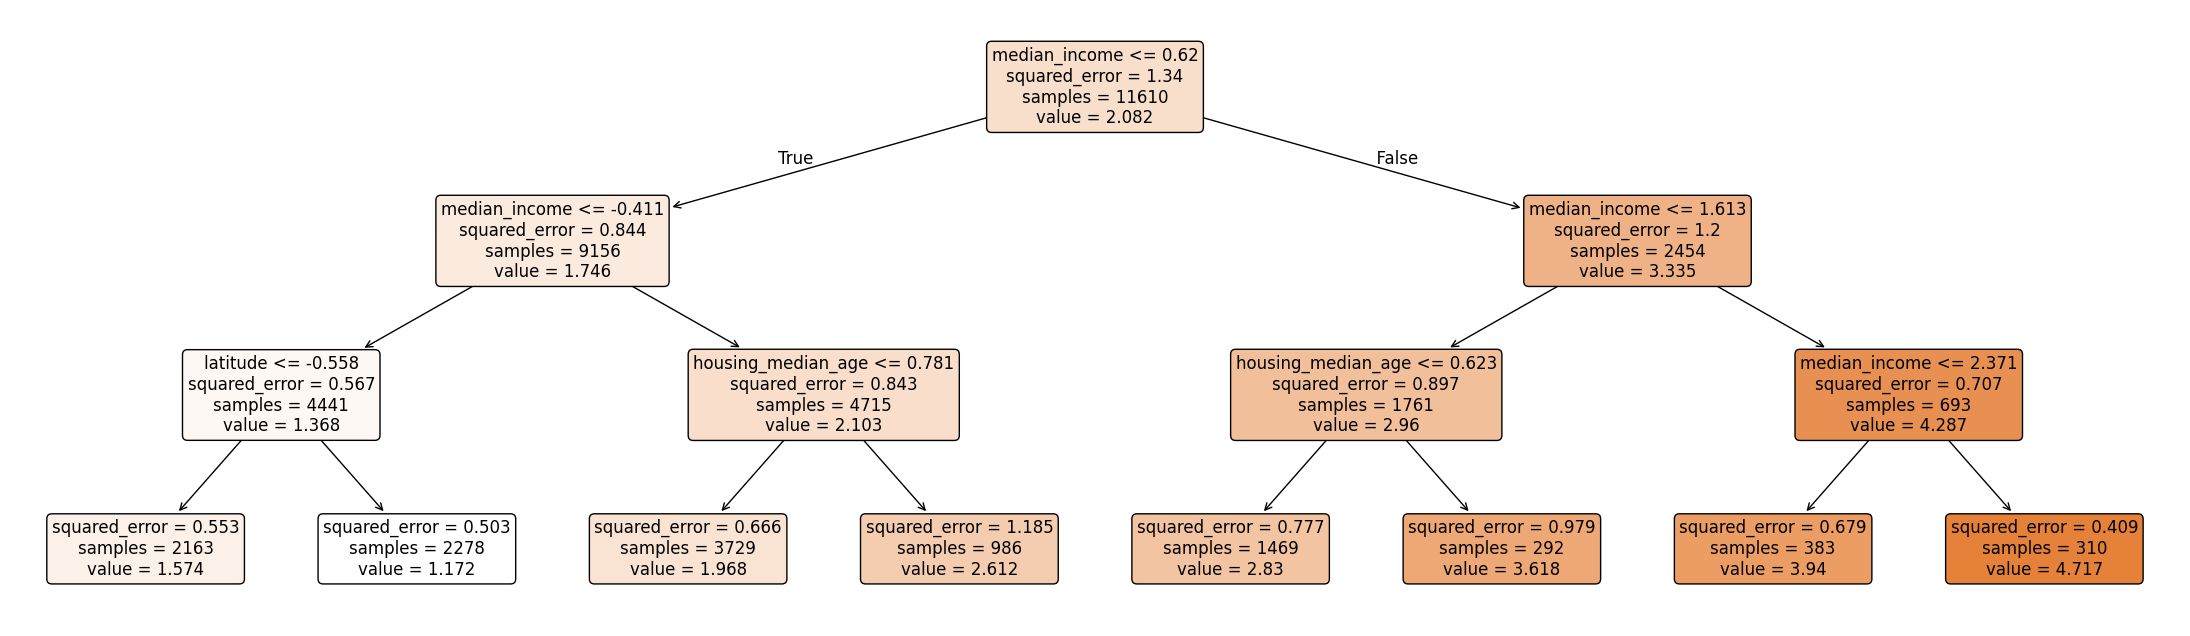

In [108]:
plt.figure(figsize=(28,8), facecolor='w')
# Create the tree plot:

a = tree.plot_tree(dt_reg_pipeline[-1], 
                   feature_names= X.columns,
                   rounded=True,
                   filled=True,
                   fontsize=12)

In [109]:
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules)

|--- feature_7 <= 0.62
|   |--- feature_7 <= -0.41
|   |   |--- feature_1 <= -0.56
|   |   |   |--- value: [1.57]
|   |   |--- feature_1 >  -0.56
|   |   |   |--- value: [1.17]
|   |--- feature_7 >  -0.41
|   |   |--- feature_2 <= 0.78
|   |   |   |--- value: [1.97]
|   |   |--- feature_2 >  0.78
|   |   |   |--- value: [2.61]
|--- feature_7 >  0.62
|   |--- feature_7 <= 1.61
|   |   |--- feature_2 <= 0.62
|   |   |   |--- value: [2.83]
|   |   |--- feature_2 >  0.62
|   |   |   |--- value: [3.62]
|   |--- feature_7 >  1.61
|   |   |--- feature_7 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_7 >  2.37
|   |   |   |--- value: [4.72]



## Using the tree for Prediction

In [110]:
test_labels_pred = dt_reg_pipeline.predict(X_test)

## Evaluating the Tree

In [111]:
mse = mean_squared_error(y_test, test_labels_pred)
mae = mean_absolute_error(y_test, test_labels_pred)
r2 = r2_score(y_test, test_labels_pred)

print("The best performance ---->")
print('MAE is:', mae)
print('MSE is:', mse)
print('R2 Score:', r2)


The best performance ---->
MAE is: 0.6133317832117446
MSE is: 0.6798994491333683
R2 Score: 0.48617733795441764


In [112]:
dt_reg_pipeline = Pipeline([
    ("feature_scaling", StandardScaler()),
    ("dt_reg", DecisionTreeRegressor(random_state=42))
])

dt_reg_cv_results = cross_validate(dt_reg_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error',
                                   return_train_score=True, return_estimator=True)


dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

## Let's tune with hyper parameter Using GridseachCV

In [115]:
param_grid= {'dt_reg__max_depth' : range(1,20),
             'dt_reg__min_samples_split': range(2,8)}

dt_grid_search = GridSearchCV(dt_reg_pipeline, param_grid=param_grid, n_jobs=2, cv=cv, scoring='neg_mean_absolute_error', 
                              return_train_score=True)

dt_grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'dt_reg__max_depth': range(1, 20), 'dt_reg__min_samples_split': range(2, 8)}"
,scoring,'neg_mean_absolute_error'
,n_jobs,2
,refit,True
,cv,ShuffleSplit(...ain_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [116]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]

In [117]:
print(f"Best Mean absolute error of decision tree regression model on the train set: \n"
       f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of decision tree regression model on the test set: \n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of decision tree regression model on the train set: 
0.254 +/- 0.005
Mean absolute error of decision tree regression model on the test set: 
0.423 +/- 0.005


In [118]:
print ("Mean cross validated score of the best estimator is: ", -1*dt_grid_search.best_score_)
print("The best parameter value is:", dt_grid_search.best_params_)

Mean cross validated score of the best estimator is:  0.4230734750334846
The best parameter value is: {'dt_reg__max_depth': 12, 'dt_reg__min_samples_split': 7}


# Ensemble learning (Bagging, Boosting, RandomForest, Adaboost etc)

In [119]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [134]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True,
                                return_estimator=True)
    
    cv_train_error = -1 * cv_results["train_score"]
    cv_test_error = -1 * cv_results["test_score"]

    print(f"On Average, {name} makes an error of \n"
          f"{cv_train_error.mean()} +/- {cv_train_error.std()}")
    
    print(f"On Average, {name} makes an error of \n"
        f"{cv_test_error.mean()} +/- {cv_test_error.std()}")
    

## Decision Tree Regressor

In [135]:
train_regressor(DecisionTreeRegressor(), X_train, y_train, cv, 'decision tree regressor')

On Average, decision tree regressor makes an error of 
3.1884845036998e-17 +/- 2.775332848853252e-18
On Average, decision tree regressor makes an error of 
0.45697967700258396 +/- 0.0072196188638684435


## Bagging Regressor

In [137]:
train_regressor(BaggingRegressor(), X_train, y_train, cv, 'Bagging regressor')

On Average, Bagging regressor makes an error of 
0.1397532807978036 +/- 0.0010251540389918838
On Average, Bagging regressor makes an error of 
0.35104442887596904 +/- 0.0033778412635657265


##  RandomForest

### Param Search for Random Forest Regressor

In [140]:
param_distribution = {
    "n_estimators" : [1,2,5,10,20,50,100,200,500],
    "max_leaf_nodes" : [2,5,10,20,50,100]
}

search_cv = RandomizedSearchCV(RandomForestRegressor(n_jobs=2),
                               param_distributions=param_distribution,
                               scoring='neg_mean_absolute_error', n_iter=10, random_state=True, n_jobs=2)

search_cv.fit(X_train, y_train)

columns = [f"param_{name}" for name in param_distribution.keys()]
columns += ["mean_test_error", "std_test_error" ]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values (by="mean_test_error")

,param_n_estimators,param_max_leaf_nodes,mean_test_error,std_test_error
5,5,100,0.412646,0.009081
8,2,100,0.431607,0.008409
2,500,50,0.441348,0.009114
7,20,50,0.444491,0.011262
6,200,20,0.506490,0.009014
3,50,20,0.507240,0.008380
0,10,20,0.507264,0.011504
4,20,20,0.508239,0.007979
9,2,10,0.582318,0.009358
1,5,2,0.731481,0.009423


In [143]:
error = -search_cv.score(X_test,y_test)
print(f"On average, our random forest regressor makes an error of {error*100000} k")

On average, our random forest regressor makes an error of 40841.159799331326 k


## Boosting

In [145]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [146]:
def train_regressor(estimator, X_train, y_train, cv, name):
    cv_results = cross_validate(estimator, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', return_train_score=True,
                                return_estimator=True)
    
    cv_train_error = -1 * cv_results["train_score"]
    cv_test_error = -1 * cv_results["test_score"]

    print(f"On Average, {name} makes an error of \n"
          f"{cv_train_error.mean()} +/- {cv_train_error.std()}")
    
    print(f"On Average, {name} makes an error of \n"
        f"{cv_test_error.mean()} +/- {cv_test_error.std()}")

## AdaBoost Regressor

In [147]:
train_regressor(AdaBoostRegressor(), X_train, y_train, cv, 'AdaBoostRegressor')

On Average, AdaBoostRegressor makes an error of 
0.8111530571452896 +/- 0.04414156930926393
On Average, AdaBoostRegressor makes an error of 
0.8166477367708639 +/- 0.04278700582623077


## Gradient Boosting Regressor

In [148]:
train_regressor(GradientBoostingRegressor(), X_train, y_train, cv, 'GradientBoostingRegressor')

On Average, GradientBoostingRegressor makes an error of 
0.36635884661422136 +/- 0.0029314423472758338
On Average, GradientBoostingRegressor makes an error of 
0.38419773361835047 +/- 0.005941662082188882


## XGBoost

### Extreme gradient boosting (XGBoost) is the latest boosting technique. It is more regularized form of gradient boosting. With regularization, it is able to achieve better generalization performance than gradient boosting.

In [149]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
